In [1]:
%matplotlib inline
import os
import shutil
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
from pandas_datareader import data as pdr
from bs4 import BeautifulSoup


# Задание 1.

Вы - менеджер по продажам в нефтехимической компании. Вы ведете несколько ключевых клиентов, которые закупают продукты вашей компании. Ваша компания запускает новый продукт - "Волшебный белый порошок" (ВБП), который по своим свойствам похож на тот, что уже есть на рынке. Ваши клиенты предпочитают формульный подход к ценообразованию. Вам нужно предложить клиентам формулу расчета цены на ВБП. В зависимости от объемов, которые покупают клиенты, им может быть предложена скидка.

### Дополнительные вводные:

Так как продукт Б новый, возможно стоит предложить дисконт от цены Продукта А. Продукт производиться из нефти. Один из известных способов производства предполагает что из 16 баррелей нефти сделают одну тонну ВБП, а затраты на производство в районе 400 евро.

In [2]:
# Из данных есть:
# Цены на продукт А, который уже есть на рынке Европы
# ----- октябрь 2018 - 1600 eur
# ----- ноябрь 2018 - 1550 eur
# ----- февраль 2019 - 1300 eur

# Котировки нефти, курс eur/usd
dbc = pd.read_excel('cur_oil.xlsx')

# Затраты на производство
PRODUCTION_COST = 400 # (EUR)

# Расходы на логистику
EU_LOGISTIC_COST_EUR = 30 # в Европу в евро
CN_LOGISTIC_COST_USD = 130 # в Китай в долларах

# * Справочная информация по клиентам(объемы, локации, комментарии) 
customers = {
    'Monty':{
        'location':'EU',
        'volumes':200,
        'comment':'moving_average'
    },
    
    'Triangle':{
        'location':'CN',
        'volumes': 30,
        'comment': 'monthly'
    },
    'Stone':{
        'location':'EU',
        'volumes': 150,
        'comment': 'moving_average'
    },
    'Poly':{
        'location':'EU',
        'volumes': 70,
        'comment': 'monthly'
    }
}
# Скидки
discounts = {'up to 100': 0.01, # 1%
             'up to 300': 0.05, # 5%
             '300 plus': 0.1}   #10%


### Что нужно сделать?

1. Проанализировать имеющиеся данные.
2. Определить базовую формулу цены на условиях FCA (цена на заводе). То есть как бы выглядела цена на исторических данных.
3. Отобразить на графике.
4. Сделать расчет возможной цены по формуле для каждого из клиентов на условиях DDP (цена с доставкой). Записать все в один эксель файл, на разных листах. Каждый лист - название клиента.
5. Предложить формулу цены каждому из клиентов на условиях DDP (цена с доставкой).
- Создать директорию «для клиентов» и в ней сложить  файлы с расчетами.
- Каждый клиент - отдельный файл (любой из docx, xlsx, pptx, pdf)  с именем клиента… 

### В результате должно быть 3 файла:
1. Ноутбук с расчетами и графиками. 
2. Скрипт, который делает расчет цены для каждого клиента в одном файле
2. Скрипт, который делает расчет цены для каждого клиента в отельном файле

In [27]:
yf.pdr_override() 
df_oil= pdr.get_data_yahoo("OIL", start="2018-01-01", end="2019-04-30")

[*********************100%***********************]  1 of 1 downloaded


In [29]:
# df_oil

In [36]:
# df_cur = pdr.get_data_yahoo('EURUSD=X ',start="2018-01-01", end="2019-04-30")

In [37]:
# df_cur

In [47]:
df_both = pdr.get_data_yahoo('EURUSD=X OIL',start="2018-01-01", end="2019-04-30")

[                       0%                       ]

KeyboardInterrupt: 

In [44]:
df_both['Close'] = df_both['Close'].copy()

In [48]:
df_both.columns  = [pair[0] + '_' + pair[1] for pair in df_both.columns]

In [52]:
df_both = df_both[['Close_EURUSD=X','Close_OIL']].copy()

In [4]:
# df_both['Close'].to_excel('cur_oil.xlsx')
df_both = pd.read_excel('cur_oil.xlsx', parse_dates=True,)
df_both = df_both.set_index('Date')

In [5]:
df_both.head()

,EURUSD=X,OIL
Date,,
2018-01-01,1.2005,NaN
2018-01-02,1.2012,59.15
2018-01-03,1.2063,59.15
2018-01-04,1.2010,59.15
2018-01-05,1.2069,60.44


In [6]:
dbc_mean = df_both.resample('M').mean()

In [7]:
dbc_mean

,EURUSD=X,OIL
Date,,
2018-01-31,1.217691,62.261429
2018-02-28,1.235620,61.415789
2018-03-31,1.233427,62.140000
2018-04-30,1.228700,65.806190
2018-05-31,1.183278,69.606818
2018-06-30,1.167586,67.040952
2018-07-31,1.168768,70.948095
2018-08-31,1.155183,69.428696
2018-09-30,1.166070,72.302632


In [8]:
# dbc_mean.columns = [pair[0]+ '_' + pair[1] for pair in dbc_mean.columns]
# dbc_mean[['Close_EURUSD=X','Close_OIL' ]]
dbc_mean['EXR_Shifted'] = dbc_mean['EURUSD=X'].shift(1)

In [9]:
dbc_mean

,EURUSD=X,OIL,EXR_Shifted
Date,,,
2018-01-31,1.217691,62.261429,NaN
2018-02-28,1.235620,61.415789,1.217691
2018-03-31,1.233427,62.140000,1.235620
2018-04-30,1.228700,65.806190,1.233427
2018-05-31,1.183278,69.606818,1.228700
2018-06-30,1.167586,67.040952,1.183278
2018-07-31,1.168768,70.948095,1.167586
2018-08-31,1.155183,69.428696,1.168768
2018-09-30,1.166070,72.302632,1.155183


In [10]:
dbc_mean['OIL_Shifted'] = dbc_mean['OIL'].shift(1)

In [11]:
dbc_mean['VBP_PRICE_EUR'] = dbc_mean['OIL_Shifted']/ dbc_mean['EXR_Shifted'] * 16 + PRODUCTION_COST

In [13]:
# dbc_mean

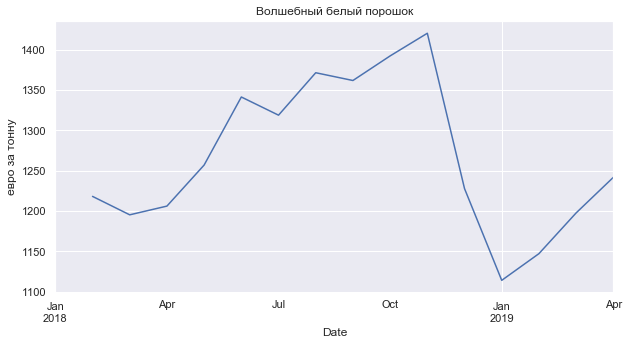

In [14]:
dbc_mean = dbc_mean[['VBP_PRICE_EUR']]

dbc_mean.VBP_PRICE_EUR.plot(figsize=(10,5)) 
plt.title('Волшебный белый порошок')
plt.ylabel("евро за тонну")
plt.show()

In [ ]:
dbc_mean

In [ ]:
customers

In [16]:
client_info = {'location': 'EU', 'volumes': 200, 'comment': 'moving_average'}
discounts = {'up to 100': 0.01, # 1%
             'up to 300': 0.05, # 5%
             '300 plus': 0.1}
# Затраты на производство
PRODUCTION_COST = 400 # (EUR)
# Расходы на логистику
EU_LOGISTIC_COST_EUR = 30 # в Европу в евро
CN_LOGISTIC_COST_USD = 130 # в Китай в долларах

dop_info = {'pr_cost': PRODUCTION_COST,
            'logistic_eu':EU_LOGISTIC_COST_EUR,
            'logistic_cn':CN_LOGISTIC_COST_USD
            }

In [17]:
def price_generator(client_info, data, dop_info=dop_info, discounts=discounts):
    if client_info['volumes'] < 100:
        discount = discounts['up to 100']
    elif 100 <= client_info['volumes'] < 300:
        discount = discounts['up to 300']
    elif client_info['volumes'] >= 300:
        discount = discounts['up to 300']
        
    if client_info['location'] =='EU':
        dbc_mean = data.resample('M').mean()
        dbc_mean['EXR_Shifted'] = dbc_mean['EURUSD=X'].shift(1)
        dbc_mean['OIL_Shifted'] = dbc_mean['OIL'].shift(1)
        dbc_mean['VBP_PRICE_EUR'] = dbc_mean['OIL_Shifted']/ dbc_mean['EXR_Shifted'] * 16 + dop_info['pr_cost']
        dbc_mean['VBP_PRICE_EUR_discount'] = dbc_mean['VBP_PRICE_EUR'] * (1-discount)
        dbc_mean['VBP_PRICE_EUR_discount_log'] = dbc_mean['VBP_PRICE_EUR_discount'] + dop_info['logistic_eu']
    elif client_info['location'] =='CN':
        dbc_mean = data.resample('M').mean()
        dbc_mean['EXR_Shifted'] = dbc_mean['EURUSD=X'].shift(1)
        dbc_mean['OIL_Shifted'] = dbc_mean['OIL'].shift(1)
        dbc_mean['VBP_PRICE_USD'] = dbc_mean['OIL_Shifted'] * 16 + dop_info['pr_cost'] * dbc_mean['EXR_Shifted'] 
        dbc_mean['VBP_PRICE_USD_discount'] = dbc_mean['VBP_PRICE_USD'] * (1-discount)
        dbc_mean['VBP_PRICE_USD_discount_log'] = dbc_mean['VBP_PRICE_USD_discount'] + dop_info['logistic_cn']
    return dbc_mean

In [19]:
!mkdir result

mkdir: result: File exists


In [21]:
# tabsdict = dict.fromkeys(customers.keys(), pd.DataFrame())
tabsdict = {k: price_generator(v, df_both) for k, v in customers.items()}


In [25]:
def create_one_output_file(tabsdict):
    """
    Записываем все в один файл
    """
    result_fpth = 'result/prices.xlsx'
    with pd.ExcelWriter(result_fpth, engine='xlsxwriter') as writer:
        for k, tab in tabsdict.items():
            tab.to_excel(writer, sheet_name=k)

In [26]:
create_one_output_file(tabsdict)

In [ ]:
def create_one_output_file(tabsdict):
    """
    Записываем все в один файл
    """
    result_fpth = 'result/customers/prices.xlsx'
    with pd.ExcelWriter(result_fpth, engine='xlsxwriter') as writer:
        for k, tab in tabsdict.items():
            tab.T.to_excel(writer, sheet_name=k)

In [ ]:
def dir_maker(dirname):
    if os.path.isdir(dirname):
        print('Директория {} уже существует'.format(dirname))
        question = input('Перезаписать? да(y)/(n)')
        if question =='y':
            shutil.rmtree(dirname)
            os.mkdir(dirname)
            print('Директория {} пераезаписана'.format(dirname))
        elif question == 'n':
            break
        else:
            raise ValueError('Ошибка! Введите либо y либо n.')
    else:
        os.mkdir(dirname)
        print('Директория {} создана'.format(dirname))

In [ ]:
dir_maker('newdir')

In [ ]:
def dir_maker(dirname):
    if os.path.isdir(dirname):
        print('Директория {} уже существует'.format(dirname))
        question = input('Перезаписать? да(y)/(n)')
        try:
            if question =='y':
               pass
            elif question == 'n':
                pass
            else:
                raise('Введено неверное значение. Укажите y либо n')
        except:
            print('wtf')
            
    else:
        os.mkdir(dirname)
        print('Директория {}'.format(dirname))



def create_output(tabsdict,one_file=True, files_for_clients=False):
    
    
    
    """
    Записываем все в один файл
    """
    result_fpth = 'result/customers/prices.xlsx'
    with pd.ExcelWriter(result_fpth, engine='xlsxwriter') as writer:
        for k, tab in tabsdict.items():
            tab.T.to_excel(writer, sheet_name=k)

# Задание 2. Продолжение

Клиенты согласились на ваше предложение. 
Вам нужно сделать написать скрипт, с помощью которого можно автоматом рассчитывать цены для всех клиентов одновременно. 
Важный момент: данные для расчета скрипт должен подтягивать сам.

В результате должно быть 3 файла
1. Ноутбук с расчетами и графиками (чтобы данные подтягивались туда)
2. Скрипт, который делает расчет цены для клиента (чтобы данные подтягивались туда сами)

In [ ]:
# 


# Задание 3. Back to Russia

К вам пришел новый клиент из России. Который использует продукт А и готов регулярно закупать ВБП для того, чтобы не быть привязанным к одному поставщику. Клиент готов забирать ВБП с завода самостоятельно.
1. На основе тех данных, которые уже есть предложите цену новому клиенту. 
2. Подготовьте скрипт, который будет использовать курс публикуемый на <a href='http://www.cbr.ru/currency_base/dynamics/'> сайте ЦБ РФ</a>.


In [ ]:
# 

# Задание 4. Check it

* Подумайте, как можно проверить корректность работы алгоритма? 
* Какие возможны ошибки?
* Придумайте тесты для проверки алгоритма


In [ ]:
# 